In [16]:
import pandas as pd
import numpy as np
import os
import scipy
from scipy.interpolate import griddata
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
from torch.nn.functional import mse_loss
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import glob

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(f"Using device: {device}")

h_nD = 30
h_n = 20
input_n = 3
learning_rate = 1e-3

class Swish(nn.Module):
    def __init__(self, inplace=True):
        super(Swish, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        if self.inplace:
            x.mul_(torch.sigmoid(x))
            return x
        else:
            return x * torch.sigmoid(x)


class Net1(nn.Module):

    #The __init__ function stack the layers of the 
    #network Sequentially 
    def __init__(self):
        super(Net1, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_n,h_n),
            #nn.Tanh(),
            #nn.Sigmoid(),
            Swish(),
            nn.Linear(h_n,h_n),
            #nn.Tanh(),
            #nn.Sigmoid(),
            Swish(),
            nn.Linear(h_n,h_n),
            #nn.Tanh(),
            #nn.Sigmoid(),
            Swish(),

            nn.Linear(h_n,1),
        )
    #This function defines the forward rule of
    #output respect to input.
    def forward(self,x):
        output = self.main(x)
        return  output

class Net2(nn.Module):

    #The __init__ function stack the layers of the 
    #network Sequentially 
    def __init__(self):
        super(Net2, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_n,h_n),
            #nn.Tanh(),
            #nn.Sigmoid(),
            Swish(),
            nn.Linear(h_n,h_n),
            #nn.Tanh(),
            #nn.Sigmoid(),
            Swish(),
            nn.Linear(h_n,h_n),
            #nn.Tanh(),
            #nn.Sigmoid(),
            Swish(),

            nn.Linear(h_n,1),
        )
    #This function defines the forward rule of
    #output respect to input.
    def forward(self,x):
        output = self.main(x)
        return  output

class Net3(nn.Module):

    #The __init__ function stack the layers of the 
    #network Sequentially 
    def __init__(self):
        super(Net3, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_n,h_n),
            #nn.Tanh(),
            #nn.Sigmoid(),
            Swish(),
            nn.Linear(h_n,h_n),
            #nn.Tanh(),
            #nn.Sigmoid(),
            Swish(),
            nn.Linear(h_n,h_n),
            #nn.Tanh(),
            #nn.Sigmoid(),
            Swish(),
            ################## below are added layers

            nn.Linear(h_n,1),
        )
    #This function defines the forward rule of
    #output respect to input.
    def forward(self,x):
        output = self.main(x)
        return  output

Using device: cuda


In [18]:
#Dataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.inputs = torch.tensor(data[:, [0, 1, 5, 7]], dtype=torch.float32).to(device)
        self.targets = torch.tensor(data[:, [2, 3, 4]], dtype=torch.float32).to(device)


    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


In [19]:
# Define absolute paths for saved weights
weights_dir = r"models\label_free"  # Use raw string (r"...") to avoid escape character issues
e_idx = -1
num_epochs = 500
net1_path = os.path.join(weights_dir, f"label_free_1_epoch_{e_idx}.pth")
net2_path = os.path.join(weights_dir, f"label_free_2_epoch_{e_idx}.pth")
net3_path = os.path.join(weights_dir, f"label_free_3_epoch_{e_idx}.pth")

def initialize_models():
    # Move models to GPU
    net1 = Net1().to(device)
    net2 = Net2().to(device)
    net3 = Net3().to(device)

    print(f"net1 is on: {next(net1.parameters()).device}")
    print(f"net2 is on: {next(net2.parameters()).device}")
    print(f"net3 is on: {next(net3.parameters()).device}")

    def init_normal(m):
        if type(m) == nn.Linear:
            nn.init.kaiming_normal_(m.weight)

    # use the modules apply function to recursively apply the initialization   
    net1.apply(init_normal)
    net2.apply(init_normal)
    net3.apply(init_normal)


    optimizer1 = optim.Adam(net1.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
    optimizer2	= optim.Adam(net2.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
    optimizer3	= optim.Adam(net3.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

    if os.path.exists(net1_path):
        net1.load_state_dict(torch.load(net1_path))
        net1.train()
        print(f"✅ Loaded weights from {net1_path}")
    else:
        e_idx = -1
        print(f"⚠️ No saved weights found at {net1_path}. Training from scratch.")

    if os.path.exists(net2_path):
        net2.load_state_dict(torch.load(net2_path))
        net2.train()
        print(f"✅ Loaded weights from {net2_path}")
    else:
        e_idx = -1
        print(f"⚠️ No saved weights found at {net2_path}. Training from scratch.")

    if os.path.exists(net3_path):
        net3.load_state_dict(torch.load(net3_path))
        net3.train()
        print(f"✅ Loaded weights from {net3_path}")
    else:
        e_idx = -1
        print(f"⚠️ No saved weights found at {net3_path}. Training from scratch.")

    return net1, net2, net3, optimizer1, optimizer2, optimizer3

In [20]:
def compute_distance(x, y, d, n):
    """Compute the minimum distance of (x, y) from the nearest circular post."""
    tilt = 0.4/n
    centers = [(0, 0), (0, 0.4), (0.4, tilt), (0.4, 0.4+tilt)]
    
    distances = torch.full_like(x, float("inf"))  # Initialize distances with large values

    for cx, cy in centers:
        r = d / 2
        distance_to_post = torch.sqrt((x - cx) ** 2 + (y - cy) ** 2) - r
        distances = torch.minimum(distances, distance_to_post)  # Take the minimum distance

    return torch.maximum(distances, torch.tensor(0.0))  # Set negative distances to zero

def smooth_distance_to_posts(x, y, d, n, alpha=128.0, beta=50.0):
    """
    Smooth, differentiable approximation to the clamped min distance to 4 circular posts.

    Parameters
    ----------
    x, y, d, n : [N,1] tensors (requires_grad OK)
        n is used to compute tilt = 0.4 / n.
    alpha : float
        Softmin sharpness. Larger -> closer to true min. Try 32–128.
    beta : float
        Softplus sharpness. Larger -> closer to ReLU. Try 10–50.

    Returns
    -------
    dist_mask : [N,1] tensor >= 0
        Smoothly zero inside posts; smoothly ramps outside.
    """
    tilt = 0.4 / n  # [N,1]

    # Centers, broadcast to [N,4]
    cx = torch.cat([
        torch.zeros_like(x),            # x=0  (post 1)
        torch.zeros_like(x),            # x=0  (post 2)
        torch.full_like(x, 0.4),        # x=0.4(post 3)
        torch.full_like(x, 0.4)         # x=0.4(post 4)
    ], dim=1)

    cy = torch.cat([
        torch.zeros_like(y),            # y=0
        torch.full_like(y, 0.4),        # y=0.4
        tilt,                           # y=tilt
        0.4 + tilt                      # y=0.4+tilt
    ], dim=1)

    r = (d / 2).expand_as(cx)           # [N,4]

    # Signed distance to each post (neg inside)
    dist_each = torch.sqrt((x - cx)**2 + (y - cy)**2 + 1e-12) - r  # [N,4]

    # Softmin across posts
    # scale inputs to control sharpness; detach to avoid overflow hazard
    dist_softmin = -torch.logsumexp(-alpha * dist_each, dim=1, keepdim=True) / alpha  # [N,1]

    # Smooth clamp >=0
    dist_mask = F.softplus(dist_softmin, beta=beta)  # ~ReLU(dist_softmin)

    return dist_mask

def criterion(x_batch, y_batch, net1, net2, net3, mse_loss, rho=1.0, nu=0.01):
    """
    Computes the loss based on physics-based PDE constraints and data loss.

    Args:
    - x_batch: Input tensor (batch of input values)
    - y_batch: Target tensor (batch of true output values)
    - net1, net2, net3: Neural network models for u, v, and p
    - mse_loss: MSE loss function
    - rho: Density parameter for PDE constraints
    - nu: Viscosity parameter for PDE constraints

    Returns:
    - Total loss: Sum of physics loss and data loss
    """
    x, y, d = x_batch[:, 0:1], x_batch[:, 1:2], x_batch[:, 2:3]
    n = torch.full_like(x, 10.0)
    # n = x_batch[:, 3:4]

    x.requires_grad_()
    y.requires_grad_()
    d.requires_grad_()
    # n.requires_grad_()

    net_in = torch.cat((x, y, d), dim=1)
    # net_in = torch.cat((x, y, d, n), dim=1)

    u = net1(net_in)
    v = net2(net_in)
    p = net3(net_in)

    u = u.view(len(u),-1)
    v = v.view(len(v),-1)
    p = p.view(len(p),-1)

    # Compute distance to the nearest circular post
    distances = smooth_distance_to_posts(x, y, d, n)

    u_hard = distances * u
    v_hard = distances * v
    p_hard = p

    u_x = torch.autograd.grad(u_hard,x,grad_outputs=torch.ones_like(x),create_graph = True,only_inputs=True)[0]
    u_xx = torch.autograd.grad(u_x,x,grad_outputs=torch.ones_like(x),create_graph = True,only_inputs=True)[0]
    u_y = torch.autograd.grad(u_hard,y,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
    u_yy = torch.autograd.grad(u_y,y,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
    p_x = torch.autograd.grad(p_hard,x,grad_outputs=torch.ones_like(x),create_graph = True,only_inputs=True)[0]
    #P_xx = torch.autograd.grad(p_x,x,grad_outputs=torch.ones_like(x),create_graph = True,only_inputs=True)[0]
    loss_1 = (u_hard*u_x+v_hard*u_y-nu*(u_xx+u_yy)+1/rho*p_x)

    v_x = torch.autograd.grad(v_hard,x,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
    v_xx = torch.autograd.grad(v_x,x,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
    
    v_y = torch.autograd.grad(v_hard,y,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
    
    v_yy = torch.autograd.grad(v_y,y,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
    P_y = torch.autograd.grad(p_hard,y,grad_outputs=torch.ones_like(y),create_graph = True,only_inputs=True)[0]
    #P_yy = torch.autograd.grad(P_y,y,grad_outputs=torch.ones_like(x),create_graph = True,allow_unused = True)[0]


    loss_2 = (u_hard*v_x+v_hard*v_y - nu*(v_xx+v_yy)+1/rho*P_y)
    #Main_deriv = torch.cat((u_x,u_xx,u_y,u_yy,P_x,v_x,v_xx,v_y,v_yy,P_y),1)
    loss_3 = (u_x + v_y)
    #loss_3 = u_x**2 + 2*u_y*v_x + v_y**2+1/rho*(P_xx + P_yy)
    #loss_3 = loss_3*100

    loss_1 = mse_loss(loss_1, torch.zeros_like(loss_1)) * 100
    loss_2 = mse_loss(loss_2, torch.zeros_like(loss_2)) * 100
    loss_3 = mse_loss(loss_3, torch.zeros_like(loss_3)) * 100

    loss_4 = mse_loss(u, y_batch[:, 0:1]) / 10
    loss_5 = mse_loss(v, y_batch[:, 1:2])
    loss_6 = mse_loss(p, y_batch[:, 2:3]) / 500


    loss = loss_1 + loss_2 + loss_3 + loss_4 + loss_6

    return loss, loss_1, loss_2, loss_3, loss_4, loss_5, loss_6


In [21]:
#loss track

def main():
    # Load dataset (modify file path accordingly)
    # file_path = os.path.join(os.getcwd(), "data/merged_dataset_REU.parquet")

    # Load data using pandas and convert to NumPy array
    # df = pd.read_parquet(file_path)  # Load Parquet file
    # data = df.to_numpy(dtype=np.float32)  # Convert to NumPy array

    csv_dir      = os.path.join(os.getcwd(), "data", "csv")
    pattern      = os.path.join(csv_dir, "W_*_10_1.csv") 
    csv_paths    = sorted(glob.glob(pattern))           

    if not csv_paths:
        raise FileNotFoundError(f"No files matched: {pattern}")

    frames = [pd.read_csv(p) for p in csv_paths]
    df     = pd.concat(frames, ignore_index=True)
    data        = df.to_numpy(dtype=np.float32)
    
    dataset = CustomDataset(data)
    drt = len(dataset)
    dataloader = DataLoader(dataset, batch_size=10000, shuffle=True)
    print(drt)
    num_batches = len(dataloader)
    print(num_batches)

    # Initialize models and optimizers
    net1, net2, net3, optimizer1, optimizer2, optimizer3 = initialize_models()

    # Training loop
    mse_loss = nn.MSELoss()
    start_time = time.time()
    
    # Initialize minimum loss to a large value
    min_loss = float('inf')
    
    # Lists to store loss history
    loss_history = {
        'epoch': [],
        'batch': [],
        'loss': [],
        'loss_1': [],
        'loss_2': [],
        'loss_3': [],
        'loss_4': [],
        'loss_5': [],
        'loss_6': []
    }

    loss_history_by_epoch = {
        'epoch': [],
        'loss': [],
        'loss_1': [],
        'loss_2': [],
        'loss_3': [],
        'loss_4': [],
        'loss_5': [],
        'loss_6': []
    }
    
    for epoch in range(e_idx+1, num_epochs):
        total_loss, total_loss_1, total_loss_2, total_loss_3, total_loss_4, total_loss_5, total_loss_6 = 0, 0, 0, 0, 0, 0, 0
        num_batches = len(dataloader)
        batch_idx = 0
        
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
            net1.zero_grad()
            net2.zero_grad()
            net3.zero_grad()

            loss, loss_1, loss_2, loss_3, loss_4, loss_5, loss_6 = criterion(x_batch, y_batch, net1, net2, net3, mse_loss)
            loss.backward()

            optimizer1.step()
            optimizer2.step()
            optimizer3.step()

            # Store losses in history
            loss_history['epoch'].append(epoch)
            loss_history['batch'].append(batch_idx)
            loss_history['loss'].append(loss.item())
            loss_history['loss_1'].append(loss_1.item())
            loss_history['loss_2'].append(loss_2.item())
            loss_history['loss_3'].append(loss_3.item())
            loss_history['loss_4'].append(loss_4.item())
            loss_history['loss_5'].append(loss_5.item())
            loss_history['loss_6'].append(loss_6.item())

    
            # Accumulate loss values
            total_loss += loss.item()
            total_loss_1 += loss_1.item()
            total_loss_2 += loss_2.item()
            total_loss_3 += loss_3.item()
            total_loss_4 += loss_4.item()
            total_loss_5 += loss_5.item()
            total_loss_6 += loss_6.item()

            batch_idx += 1
    
        # Compute average loss
        avg_loss = total_loss / num_batches
        avg_loss_1 = total_loss_1 / num_batches
        avg_loss_2 = total_loss_2 / num_batches
        avg_loss_3 = total_loss_3 / num_batches
        avg_loss_4 = total_loss_4 / num_batches
        avg_loss_5 = total_loss_5 / num_batches
        avg_loss_6 = total_loss_6 / num_batches

        # Store average losses by epoch
        loss_history_by_epoch['epoch'].append(epoch)
        loss_history_by_epoch['loss'].append(avg_loss)
        loss_history_by_epoch['loss_1'].append(avg_loss_1)
        loss_history_by_epoch['loss_2'].append(avg_loss_2)
        loss_history_by_epoch['loss_3'].append(avg_loss_3)
        loss_history_by_epoch['loss_4'].append(avg_loss_4)
        loss_history_by_epoch['loss_5'].append(avg_loss_5)
        loss_history_by_epoch['loss_6'].append(avg_loss_6)
        
        # Save models if the current loss is lower than the minimum loss
        if avg_loss < min_loss:
            min_loss = avg_loss
            torch.save(net1.state_dict(), f'models/label_free/label_free_1_epoch_{epoch}.pth')
            torch.save(net2.state_dict(), f'models/label_free/label_free_2_epoch_{epoch}.pth')
            torch.save(net3.state_dict(), f'models/label_free/label_free_3_epoch_{epoch}.pth')
            print(f"Epoch {epoch}: New minimum loss {min_loss:.7f}, models saved")
    
        if epoch % 2 == 0:
            elapsed_time = time.time() - start_time
            print(f"Epoch [{epoch}/{num_epochs}], Avg Loss: {avg_loss:.7f}, Avg Loss_1: {avg_loss_1:.7f}, "
                  f"Avg Loss_2: {avg_loss_2:.7f}, Avg Loss_3: {avg_loss_3:.7f}, Avg Loss_4: {avg_loss_4:.7f}, Avg Loss_5: {avg_loss_5:.7f}, Avg Loss_6: {avg_loss_6:.7f}, Time: {elapsed_time:.2f} sec")
            start_time = time.time()

    # Save losses to CSV
    loss_df = pd.DataFrame(loss_history)

    loss_csv_path = 'results/label_free/training_losses_label_free.csv'
    
    if os.path.exists(loss_csv_path):
        existing_loss_df = pd.read_csv(loss_csv_path)
    else:
        existing_loss_df = None

    if existing_loss_df is not None:
        loss_df = pd.concat([existing_loss_df, loss_df], ignore_index=True)

    loss_df.to_csv('results/label_free/training_losses_label_free.csv', index=False)
    
    # Plot loss curves
    plt.figure(figsize=(12, 8))
    plt.plot(loss_history_by_epoch['epoch'], loss_history_by_epoch['loss'], label='Total Loss')
    plt.plot(loss_history_by_epoch['epoch'], loss_history_by_epoch['loss_1'], label='Loss 1')
    plt.plot(loss_history_by_epoch['epoch'], loss_history_by_epoch['loss_2'], label='Loss 2')
    plt.plot(loss_history_by_epoch['epoch'], loss_history_by_epoch['loss_3'], label='Loss 3')
    plt.plot(loss_history_by_epoch['epoch'], loss_history_by_epoch['loss_4'], label='Loss 4')
    plt.plot(loss_history_by_epoch['epoch'], loss_history_by_epoch['loss_5'], label='Loss 5')
    plt.plot(loss_history_by_epoch['epoch'], loss_history_by_epoch['loss_6'], label='Loss 6')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Epoch')
    plt.legend()
    plt.yscale('log')  # Use log scale for better visualization
    plt.grid(True)
    plt.savefig('results/label_free/loss_curves_label_free.png')
    plt.show()

    return net1, net2, net3


180000
18
net1 is on: cuda:0
net2 is on: cuda:0
net3 is on: cuda:0
⚠️ No saved weights found at models\label_free\label_free_1_epoch_-1.pth. Training from scratch.
⚠️ No saved weights found at models\label_free\label_free_2_epoch_-1.pth. Training from scratch.
⚠️ No saved weights found at models\label_free\label_free_3_epoch_-1.pth. Training from scratch.
Epoch 0: New minimum loss 20.2974689, models saved
Epoch [0/500], Avg Loss: 20.2974689, Avg Loss_1: 16.8633641, Avg Loss_2: 1.5692930, Avg Loss_3: 0.7756150, Avg Loss_4: 0.1800435, Avg Loss_5: 0.1131273, Avg Loss_6: 0.9091538, Time: 2.65 sec
Epoch 1: New minimum loss 3.8865911, models saved
Epoch 2: New minimum loss 2.0626493, models saved
Epoch [2/500], Avg Loss: 2.0626493, Avg Loss_1: 0.6710178, Avg Loss_2: 0.0171005, Avg Loss_3: 0.2981096, Avg Loss_4: 0.1708904, Avg Loss_5: 0.0527340, Avg Loss_6: 0.9055311, Time: 4.62 sec
Epoch 3: New minimum loss 1.5019244, models saved
Epoch 4: New minimum loss 1.2611879, models saved
Epoch [4/50

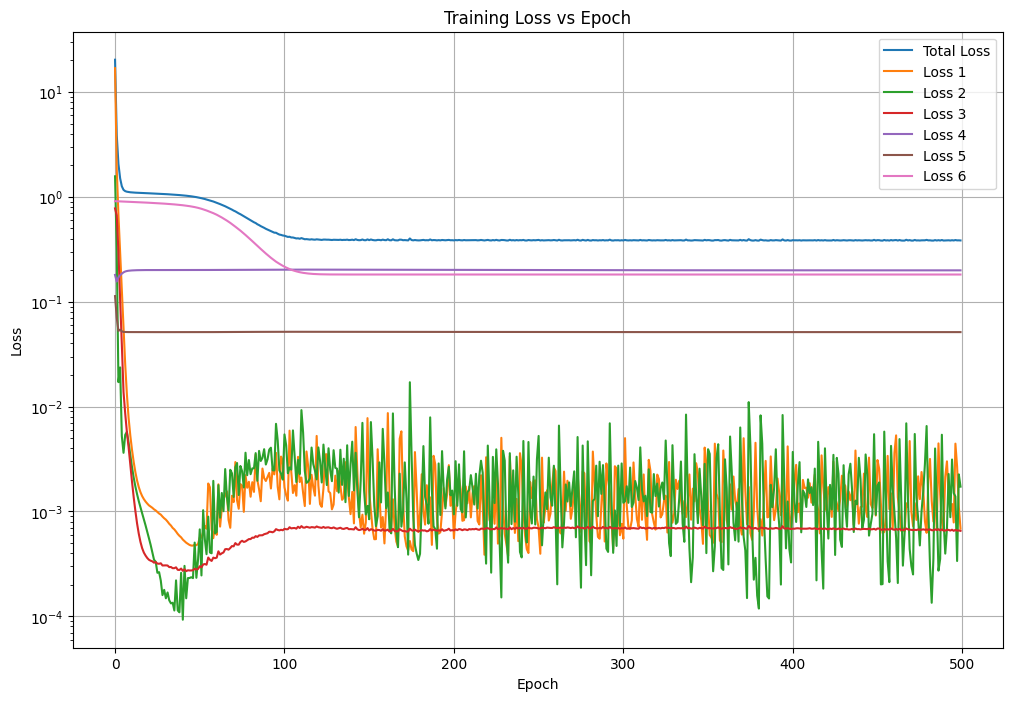

In [22]:
net1, net2, net3 = main()

In [23]:
# Set models to evaluation mode
net1.eval()
net2.eval()
net3.eval()

Net3(
  (main): Sequential(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): Swish()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Swish()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Swish()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [24]:
# PREDICTION USING HARD ENFORCEMENT

# File path
file_path = "data/csv/W_0.55_10_1.csv"

# Load CSV file
df = pd.read_csv(file_path)

# Ensure the correct columns are selected for input
input_data = df.iloc[:, [0, 1, 5, 7]].values  # Selecting columns (x, y, d, N)
output_data = df.iloc[:, [2, 3, 4]].values  # Selecting columns (u, v, p)

# Convert to PyTorch tensor and move to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)

def compute_distance(x, y, d, n):
    """Compute the minimum distance of (x, y) from the nearest circular post."""
    tilt = 0.4 / n
    centres = torch.tensor([[0.0, 0.0],
                            [0.0, 0.4],
                            [0.4, tilt],
                            [0.4, 0.4 + tilt]],
                           device=x.device, dtype=x.dtype)      

    pts   = torch.stack((x.squeeze(-1), y.squeeze(-1)), dim=-1)   
    diff  = pts.unsqueeze(1) - centres.unsqueeze(0)         

    r              = d * 0.5                                   
    dist_to_surf   = diff.norm(dim=-1) - r                     

    signed_dist, _ = dist_to_surf.min(dim=1, keepdim=True)    

    return F.relu(signed_dist)  

# Extract individual elements
x, y, d = input_tensor[:, 0], input_tensor[:, 1], input_tensor[:, 2]

# Reshape x, y, d to match the expected input shape
x = x.unsqueeze(-1)  # Shape (B, 1)
y = y.unsqueeze(-1)  # Shape (B, 1)
d = d.unsqueeze(-1)  # Shape (B, 1)
# Concatenate x, y, d to form the input tensor
input_tensor = torch.cat((x, y, d), dim=1)  # Shape

# Make predictions
with torch.no_grad():
    u_pred = net1(input_tensor)
    v_pred = net2(input_tensor)
    p_pred = net3(input_tensor)

n = 10
# n = input_tensor[:, 3]

# Apply conditions
v_pred[x == 0] = 0  # If x = 0, set v_pred to zero

# Compute distance
distances = compute_distance(x, y, d, n)

# If distance is zero, set u and v to zero
mask = distances == 0
u_pred[mask] = 0
v_pred[mask] = 0

# Move predictions to CPU and convert to NumPy
u_pred = u_pred.cpu().numpy()
v_pred = v_pred.cpu().numpy()
p_pred = p_pred.cpu().numpy()


In [25]:
#prediction for NO MODIFICATION
import pandas as pd
import torch
import numpy as np

# File path
file_path = "data/csv/W_0.55_10_1.csv"

# Load CSV file
df = pd.read_csv(file_path)

# Ensure the correct columns are selected for input (same format as training)
input_data = df.iloc[:, [0, 1, 5, 7]].values  # Selecting columns (x, y, d)
output_data = df.iloc[:, [2, 3, 4]].values  # Selecting columns (x, y, d)

# Convert to PyTorch tensor and move to GPU (if available)
input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)

# Reshape input tensor to match the expected input shape
x = input_tensor[:, 0].unsqueeze(-1)  # Shape (B, 1)
y = input_tensor[:, 1].unsqueeze(-1)  # Shape (B, 1)
d = input_tensor[:, 2].unsqueeze(-1)  # Shape (B, 1)
# Concatenate x, y, d to form the input tensor
input_tensor = torch.cat((x, y, d), dim=1)  # Shape

with torch.no_grad():
    u_pred = net1(input_tensor)
    v_pred = net2(input_tensor)
    p_pred = net3(input_tensor)

# Move predictions to CPU and convert to NumPy
u_pred = u_pred.cpu().numpy()
v_pred = v_pred.cpu().numpy()
p_pred = p_pred.cpu().numpy()


In [26]:
x_grid = input_data[:, 0].reshape(-1)
y_grid = input_data[:, 1].reshape(-1)
v_actual_grid = output_data[:, 1].reshape(-1)
v_pred_grid = v_pred.flatten()
u_actual_grid = output_data[:, 0].reshape(-1)
u_pred_grid = u_pred.flatten()

In [27]:
# Create a DataFrame
df = pd.DataFrame({
    'x': x_grid,
    'y': y_grid,
    'u': u_pred_grid,
    'v': v_pred_grid
})

# Save to CSV
df.to_csv('results/label_free/csv/LF_0.55_10.csv', index=False)

print("CSV file saved successfully!")

CSV file saved successfully!


In [28]:
v_pred_grid.shape

(18000,)

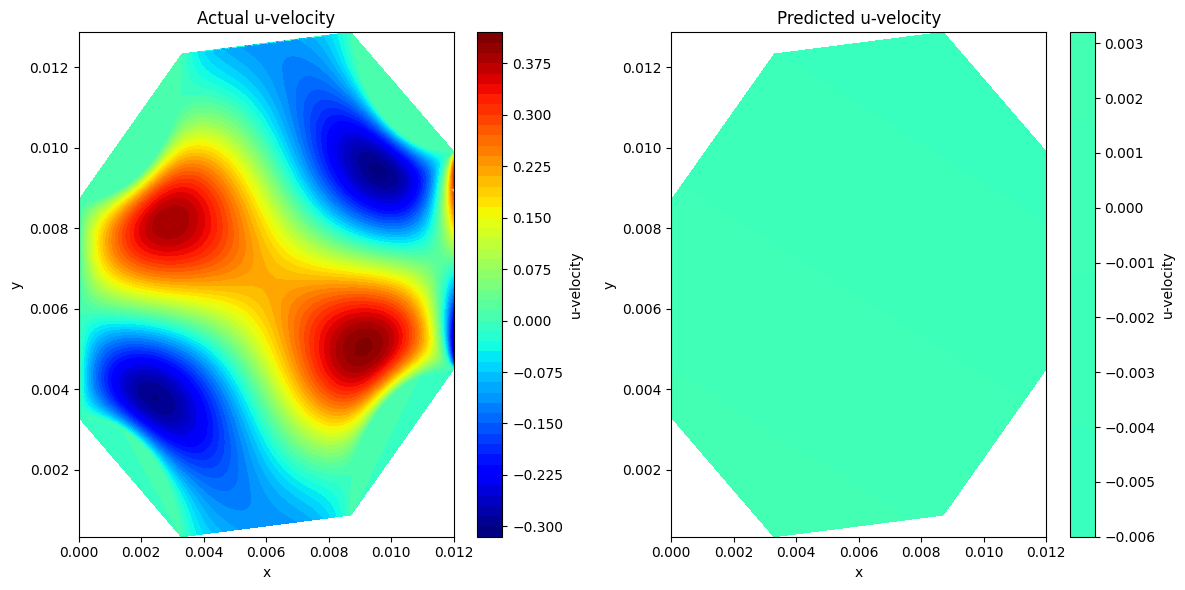

In [29]:
%matplotlib inline

# Determine the common range for colorbar
vmin = min(v_actual_grid.min(), v_pred_grid.min())
vmax = max(v_actual_grid.max(), v_pred_grid.max())

# Plotting
plt.figure(figsize=(12, 6))

# Actual u-velocity
plt.subplot(1, 2, 1)
plt.tricontourf(x_grid, y_grid, v_actual_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u-velocity')
plt.title('Actual u-velocity')
plt.xlabel('x')
plt.ylabel('y')

# Predicted u-velocity
plt.subplot(1, 2, 2)
plt.tricontourf(x_grid, y_grid, v_pred_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u-velocity')
plt.title('Predicted u-velocity')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()


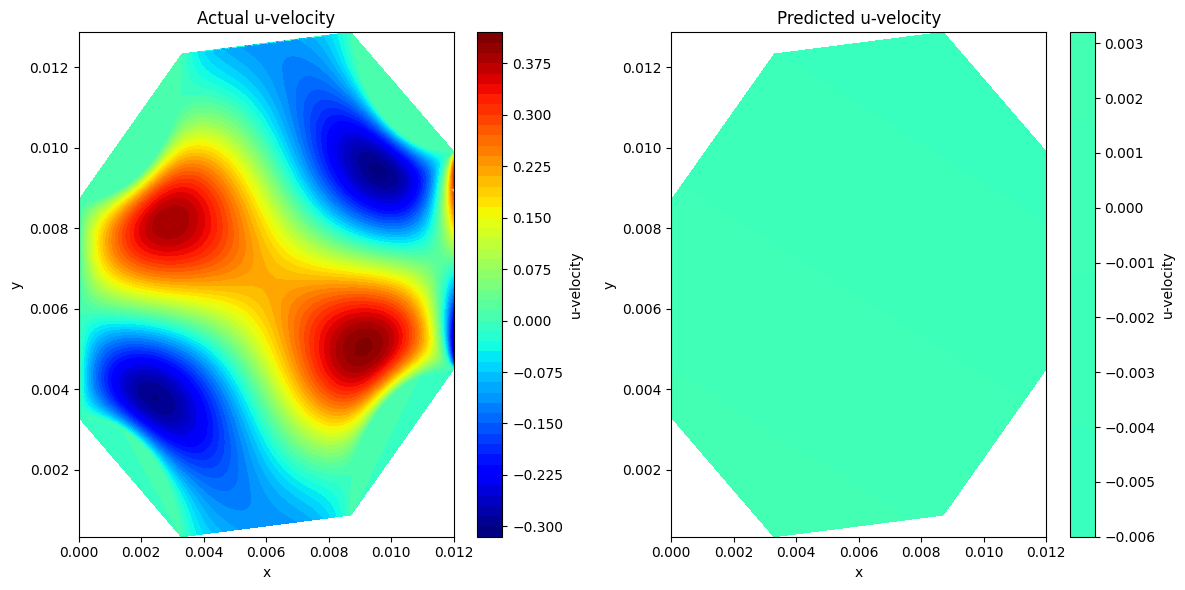

In [30]:
%matplotlib inline

# Determine the common range for colorbar
vmin = min(v_actual_grid.min(), v_pred_grid.min())
vmax = max(v_actual_grid.max(), v_pred_grid.max())

# Plotting
plt.figure(figsize=(12, 6))

# Actual u-velocity
plt.subplot(1, 2, 1)
plt.tricontourf(x_grid, y_grid, v_actual_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u-velocity')
plt.title('Actual u-velocity')
plt.xlabel('x')
plt.ylabel('y')

# Predicted u-velocity
plt.subplot(1, 2, 2)
plt.tricontourf(x_grid, y_grid, v_pred_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u-velocity')
plt.title('Predicted u-velocity')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()


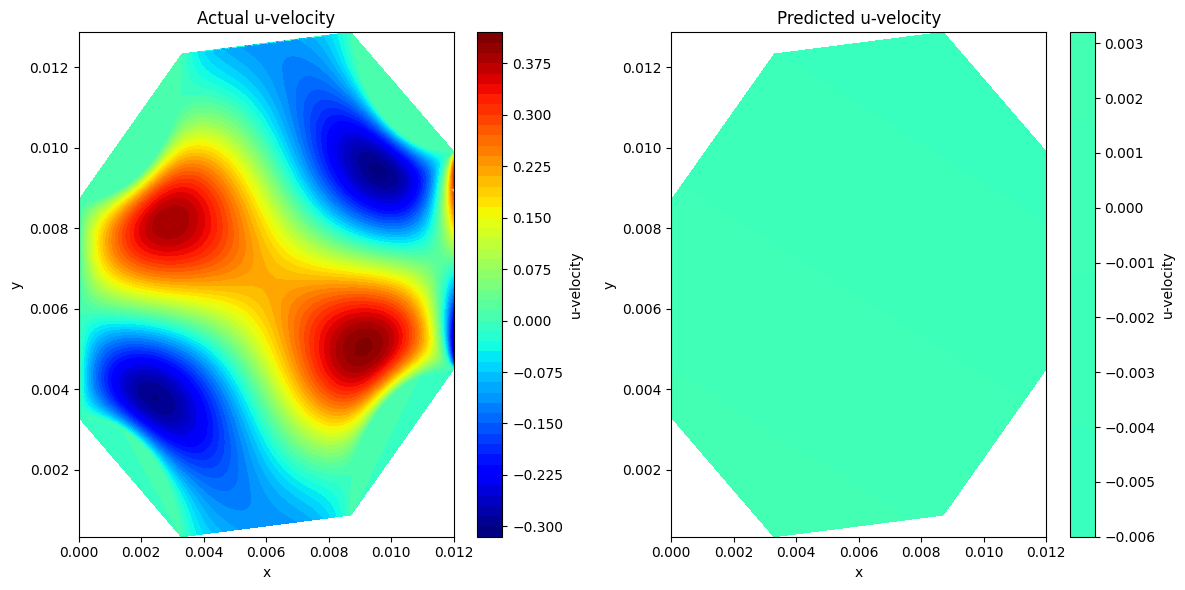

In [31]:
%matplotlib inline

# Determine the common range for colorbar
vmin = min(v_actual_grid.min(), v_pred_grid.min())
vmax = max(v_actual_grid.max(), v_pred_grid.max())

# Plotting
plt.figure(figsize=(12, 6))

# Actual u-velocity
plt.subplot(1, 2, 1)
plt.tricontourf(x_grid, y_grid, v_actual_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u-velocity')
plt.title('Actual u-velocity')
plt.xlabel('x')
plt.ylabel('y')

# Predicted u-velocity
plt.subplot(1, 2, 2)
plt.tricontourf(x_grid, y_grid, v_pred_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u-velocity')
plt.title('Predicted u-velocity')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()
